# Modeling, Submission and Recommendations

Now that we have our features ready, we will fit them into our model, and iterate through a few models to see how we can improve them. We will be working towards optimizing our Root Mean Squared Error, hereafter referred to as `rmse`.

## Quick Links:
1. [Imports](#Imports)
2. [Heatmap](#Heatmap)
3. [Linear Regression](#Linear-Regression-Model-Iterations)
    - [Model 1](#LR-model-1)
    - [Model 2](#LR-model-2)
    - [Model 3](#LR-model-3)
4. [Regularisation](#Regularisation)
    - [Ridge Model 1](#Ridge-Model-1)
    - [Lasso Model 1](#Lasso-Model-1)
    - [Elastic Net Model 1](#Elastic-Net-Model-1)
    
5. [Additional Feature Engineering](#Feature-Engineering)
6. [Final Feature Selection and Model](#Final-Feature-Selection)
7. [Kaggle Submission](#Kaggle-Submission)
8. [Conclusion](#Conclusion:) 
    -[Recommendations](#Recommendations)
    

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

from sklearn.linear_model import (LinearRegression, 
                                  Lasso, 
                                  LassoCV, 
                                  Ridge, 
                                  RidgeCV,
                                  ElasticNet,
                                  ElasticNetCV)

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score)

from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
# read in our data from the previous notebook
df = pd.read_csv('datasets/train_modeling.csv')
test = pd.read_csv('datasets/test_modeling.csv')

---

## Heatmap

Let's look at the heatmap of all our variables once again.

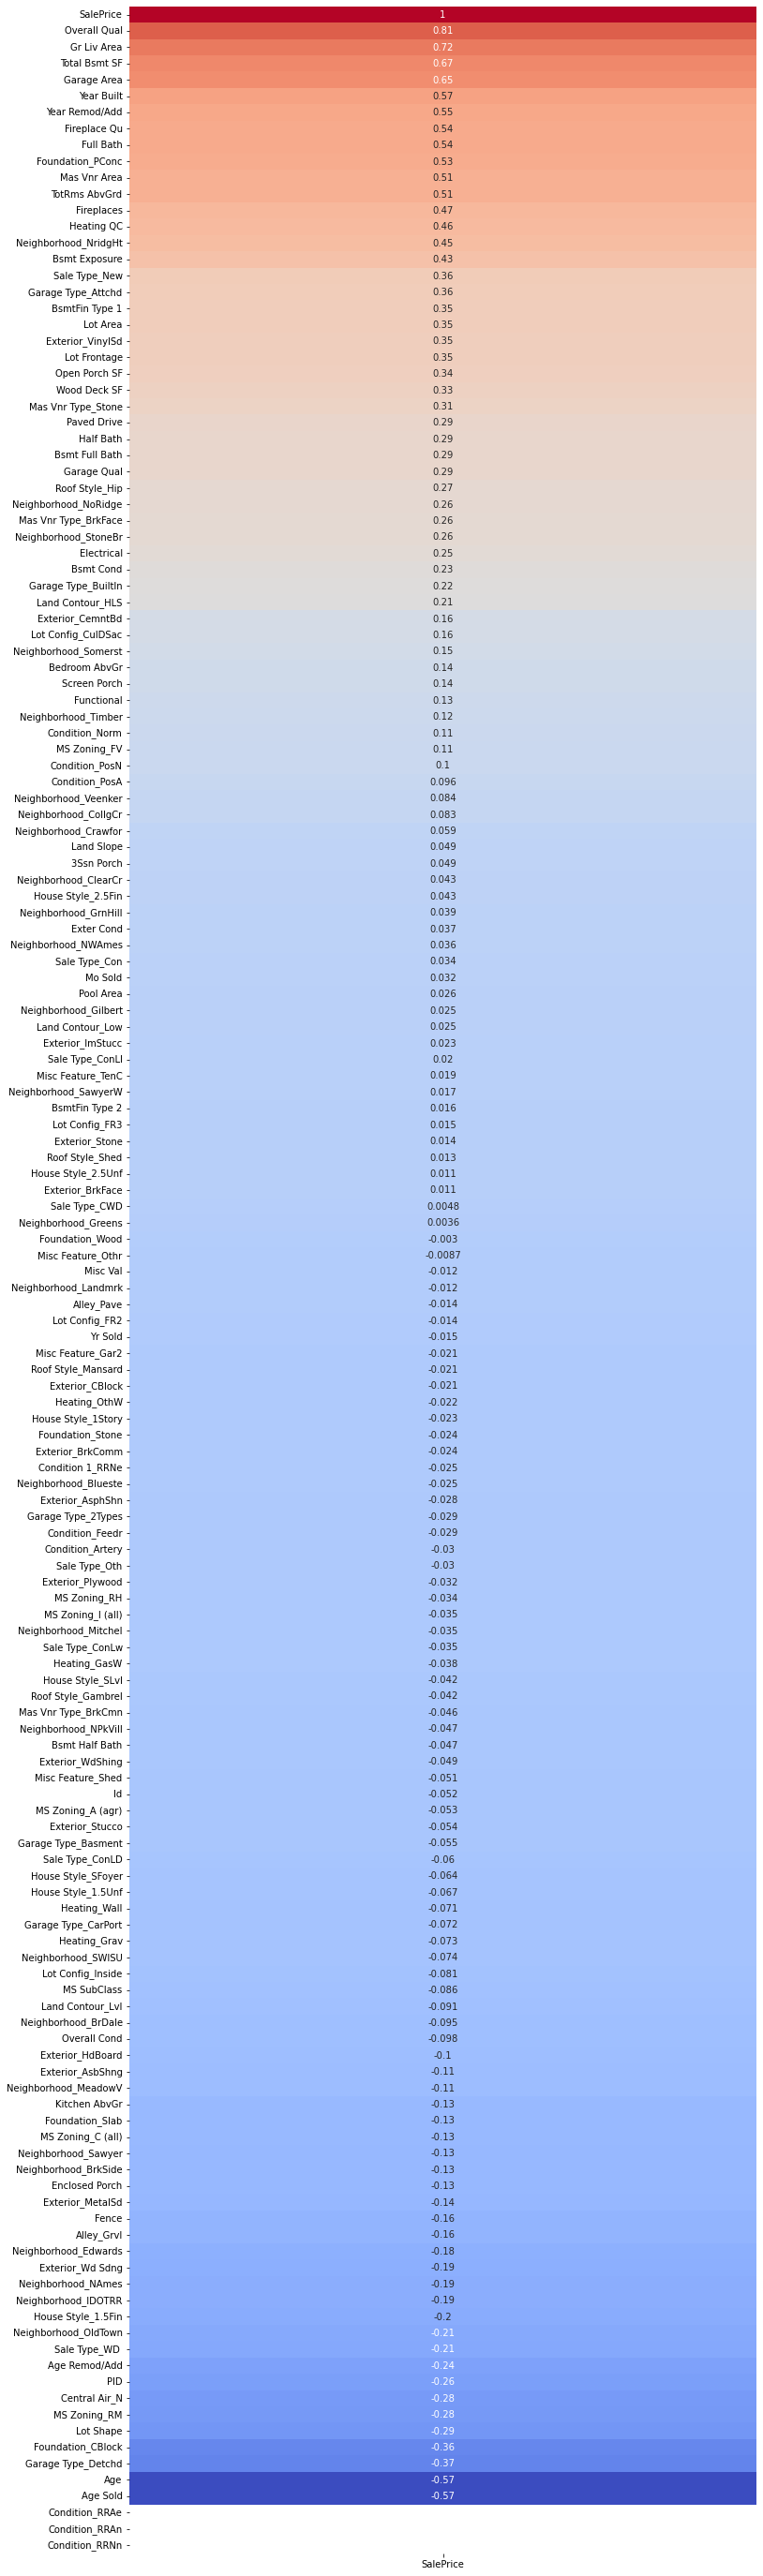

In [4]:
# Check correlation for all variables
# the hypothesis is that Square Footage, Location, and Quality 
# will affect the SalePrice the most.

plt.figure(figsize=(12,50))
sns.heatmap(df.corr()[['SalePrice']]
           .sort_values(by='SalePrice',
           ascending=False),
            cmap='coolwarm',
            annot=True,
            cbar=False
           );

As expected, `Variables` related to quality, location and square footage make the biggest difference when it comes to correlation with `SalePrice`. Additionally, we see that the `Age` of the property is also highly negatively correlated with `SalePrice`.
Let's create a simple Linear Regression model, with features that have correlation above `0.6`, and add these features into it to see what `rmse` we get.

---

## Linear Regression Model Iterations

### LR model 1

In [5]:
corr_matrix = df.corr()[['SalePrice']].sort_values(by='SalePrice',ascending=False)
min_feat_list = corr_matrix[corr_matrix['SalePrice']>0.6].index.values.tolist()
min_feat_list.remove('SalePrice')
min_feat_list.append('Age')

In [6]:
# let's create a model with only the most highly correlated features

X_min_feat = df[min_feat_list]
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(
                                        X_min_feat, 
                                        y, 
                                        test_size=0.2)

lr_min = LinearRegression()
lr_min.fit(X_train, y_train)

mse_min_feat = -cross_val_score(
    lr_min,
    X_train,
    y_train, 
    cv=5, 
    scoring='neg_mean_squared_error'
).mean()
mse_min_feat**0.5

33447.312225110894

In [7]:
# checking the test rmse against the cross_val rmse.
mean_squared_error(y_test, lr_min.predict(X_test), squared=False)

33501.15637605644

This model does not have the `Location` features, so let's add that in and see if it improves the `mean_squared_error`.

---

### LR model 2

In [8]:
min_feat_list += df.filter(like='Neighborhood').columns.tolist()

In [9]:
X_2 = df[min_feat_list]
y_2 = df['SalePrice']

X_train2, X_test2, y_train2, y_test2 = train_test_split(
                                        X_2, 
                                        y_2, 
                                        test_size=0.2)

lr_V2 = LinearRegression()
lr_V2.fit(X_train2, y_train2)
mse_with_loc = -cross_val_score(
    lr_V2,
    X_train2,
    y_train2, 
    cv=5, 
    scoring='neg_mean_squared_error'
).mean()

mse_with_loc**0.5

31064.089980703324

In [10]:
# checking the test rmse against the cross_val rmse.
mean_squared_error(y_test2, lr_V2.predict(X_test2), squared=False)

31217.778632853446

We can see that the root_mean_squared_error has in fact improved here a little compared to the previous model.

Let's add in other variables that we identified earlier as having a correlation with `SalePrice` in the "Scatterplot of Numeric vs SalePrice", found in the `Ames Housing Data - EDA Encoding and Feature Engineering` notebook.

Namely, these are:
1. features related tosquare feet
2. features related to quality
3. features related to location
4. other features, which are identified from the various plots.

---

### LR model 3

In [11]:
feat_SF = df.filter(regex='SF|Area').columns.tolist()
feat_qual = df.filter(like='Qual').columns.tolist()
feat_location = df.filter(like=('Neighborhood')).columns.tolist()
feat_other = df.filter(
    regex='Central|Heating'
    '|Roof|Config|Condition'
    '|Exterior|House|Overall Cond'
    '|Bath|Rms|Foundation|Functional').columns.tolist()
feat_set_V3 = feat_SF+feat_qual+feat_location+feat_other

In [12]:
len(df.columns)

156

In [13]:
X_V3 = df[feat_set_V3]
y_V3 = df['SalePrice']

X_trainV3, X_testV3, y_trainV3, y_testV3 = train_test_split(
                                        X_V3, 
                                        y_V3, 
                                        test_size=0.2)

lr_V3 = LinearRegression()
lr_V3.fit(X_trainV3, y_trainV3)

LinearRegression()

In [14]:
lr_V3_rsme = mean_squared_error(y_testV3, lr_V3.predict(X_testV3), squared=False)
lr_V3_rsme

25837.46631026999

In [15]:
# create a dictionary of RSME scores for comparison
rsme_scores = {'linear_regression': lr_V3_rsme}

We are definitely seeing an improvement on the model scores, however, if we run our model a few times, we can see that the `rmse` for our test data fluctuates.
At this point, it might be best to use other models, which will apply regularisation to our features, and we will see if we fare better with those instead.
We'll use the Ridge, Lasso, and ElasticNet models and we will see which one we are able to get the best `rmse` from.

---

## Regularisation

### Ridge Model 1

First we would need to standardize our features.

In [16]:
ss = StandardScaler()
X_trainV3_sc = ss.fit_transform(X_trainV3)
X_testV3_sc = ss.transform(X_testV3)

In [17]:
r_cv_alphas = np.logspace(0, 5, 100)

ridge_cv = RidgeCV(
    alphas=r_cv_alphas,
    scoring='neg_mean_squared_error',
    cv=5
)

ridge_cv.fit(X_trainV3_sc, y_trainV3)
ridge_best = Ridge(alpha=ridge_cv.alpha_)

# Let's feed this alpha back into our normal Ridge model.

ridge_best.fit(X_trainV3_sc, y_trainV3)
ridge_best_test_rmse = mean_squared_error(y_testV3, ridge_best.predict(X_testV3_sc), squared=False)
rsme_scores['Ridge Regression'] = ridge_best_test_rmse
ridge_best_test_rmse

25614.38871578719

Now let's do the same for Lasso.

---

### Lasso Model 1

In [18]:
lasso_cv = LassoCV(n_alphas=200)
lasso_cv.fit(X_trainV3_sc, y_trainV3)

LassoCV(n_alphas=200)

In [19]:
lasso_cv.alpha_

336.46239560947436

In [20]:
lasso_cv_best = Lasso(alpha = lasso_cv.alpha_)

In [21]:
cross_val_score(
    lasso_cv_best,
    X_trainV3_sc,
    y_trainV3,
    cv=5,
    scoring='neg_mean_squared_error'
).mean()

-801509817.2333852

In [22]:
lasso_cv_best.fit(X_trainV3_sc, y_trainV3)

Lasso(alpha=336.46239560947436)

In [23]:
lasso_cv_best_rmse = mean_squared_error(y_testV3, lasso_cv_best.predict(X_testV3_sc), squared=False)
rsme_scores['Lasso Regression'] = lasso_cv_best_rmse
lasso_cv_best_rmse

25076.96846004133

Next, let's put our current feature set into an ElasticNet model for dexterity.

---

### Elastic Net Model 1

In [24]:
# setting up list of alphas to check
enet_alphas = np.linspace(0.5, 1.0, 100)

# set L1 ratio to 0.5, balance between ridge and lasso.
enet_ratio = 0.5

# Instantiate model.
enet_cv = ElasticNetCV(alphas=enet_alphas, l1_ratio=enet_ratio, cv=5)

# Fit model using optimal alpha.
enet_cv = enet_cv.fit(X_trainV3, y_trainV3)

# Generate predictions.
mean_squared_error(y_testV3, enet_cv.predict(X_testV3), squared=False)

27731.506208979787

In [25]:
enet_best = ElasticNet(alpha=enet_cv.alpha_, l1_ratio=0.5)
enet_best.fit(X_trainV3, y_trainV3)
enet_best_rsme = mean_squared_error(y_testV3, enet_best.predict(X_testV3), squared=False)

In [26]:
rsme_scores['Enet Regression'] = enet_best_rsme

In [27]:
rsme_scores

{'linear_regression': 25837.46631026999,
 'Ridge Regression': 25614.38871578719,
 'Lasso Regression': 25076.96846004133,
 'Enet Regression': 27731.506208979787}

By a margin, the Lasso regression gives us the best `rmse`. Given this, we will now proceed to prepare the final model that we will use for predicting `SalePrice` values for submission on Kaggle.

Let's see if we can use the previously created Lasso model to help us cut out unneccesary features.

---

## Feature Engineering

In [28]:
pd.set_option('display.max_rows', 300)
feat_V1_df = pd.DataFrame({'feature':X_V3.columns.tolist(),
                        'coef_': lasso_cv_best.coef_})

In [29]:
feat_V1_df.head(10)

feature         coef_
0            Lot Area   7969.935020
1        Mas Vnr Area   5453.895891
2       Total Bsmt SF  10801.493127
3         Gr Liv Area  25314.546406
4         Garage Area   7565.350735
5        Wood Deck SF   2660.701190
6       Open Porch SF   1684.607436
7           Pool Area    431.733018
8  House Style_SFoyer      0.000000
9        Overall Qual  19397.916622

In [30]:
feat_V1_df.loc[feat_V1_df['coef_'] == 0, ['feature', 'coef_']]

feature  coef_
8     House Style_SFoyer    0.0
11  Neighborhood_Blueste    0.0
15  Neighborhood_CollgCr   -0.0
18  Neighborhood_Gilbert    0.0
19   Neighborhood_Greens    0.0
22  Neighborhood_Landmrk   -0.0
37  Neighborhood_Veenker    0.0
44         TotRms AbvGrd   -0.0
51    House Style_1.5Fin   -0.0
52    House Style_1.5Unf    0.0
55    House Style_2.5Unf    0.0
58      Condition 1_RRNe   -0.0
66       Roof Style_Shed    0.0
70      Foundation_Stone   -0.0
71       Foundation_Wood    0.0
72      Exterior_AsbShng   -0.0
73      Exterior_AsphShn    0.0
76       Exterior_CBlock    0.0
79      Exterior_ImStucc   -0.0
80      Exterior_MetalSd    0.0
87      Condition_Artery   -0.0
92        Condition_RRAe    0.0
93        Condition_RRAn    0.0
94        Condition_RRNn    0.0

This DataFrame here is interesting, as it suggests a couple of things.
1. A property in the locality of `Blueste`, `CollgCr`, `Greens`, `Landmrk`, `NPkVill`, and `Sawyer` seem to have no impact on the property's `SalePrice`.
2. The number of `Full Bath` do not have an impact on `SalePrice`.
3. The `TotRms AbvGrd` does not have an impact on `SalePrice`.
4. `Garage Quality` does not have an impact on `SalePrice`.

The last two as especially suprising. The scatterplot in the EDA, Encoding and Feature Engineering notebook, suggested that there might be some relationship between the two.

We will elect to drop the features in points 2-3 and rerun the model a final time to get our final `SalePrice` predictive model. We will leave the other features alone as they are part of a set of dummified features.

---


## Final Feature Selection

In [31]:
# X_V3 is our dataframe of features, we will use this dataframe to directly change our training dataset and test dataset.
final_feat = [col for col in feat_set_V3 if col not in ['Garage Qual', 'Full Bath','TotRms AbvGrd']]

In [32]:
# with our final feature set ready, we can build our final holdout model.
# X_f stands for X final
X_f = df[final_feat]
y_f = df['SalePrice']

In [33]:
X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(
                                        X_f, 
                                        y_f, 
                                        test_size=0.2)

In [34]:
ss_f = StandardScaler()
X_f_train_sc = ss_f.fit_transform(X_f_train)
X_f_test_sc = ss_f.transform(X_f_test)

In [35]:
lasso_f = LassoCV(n_alphas=200)
lasso_f.fit(X_f_train_sc, y_f_train)

LassoCV(n_alphas=200)

In [36]:
lasso_f.alpha_

248.54426349940925

In [37]:
lasso_f = Lasso(alpha = lasso_f.alpha_)

In [38]:
lasso_f.fit(X_f_train_sc, y_f_train)

Lasso(alpha=248.54426349940925)

In [39]:
lasso_f_rsme = mean_squared_error(y_f_test, lasso_f.predict(X_f_test_sc), squared=False)
rsme_scores['Lasso Final'] = lasso_f_rsme
lasso_cv_best_rmse

25076.96846004133

There isn't much change in the `RSME`. Let's go ahead and predict the values required for kaggle. We will use all the data we have, i.e. we will do away with the `train_test_split` for this kaggle model.

---

## Kaggle Submission

In [40]:
# restating our final feature to remove any confusion
X_f = df[final_feat]
y_f = df['SalePrice']

# adding our kaggle test features
X_test_kaggle = test[final_feat]

In [41]:
ss_kaggle = StandardScaler()
X_f_sc = ss_kaggle.fit_transform(X_f)
X_test_k_sc = ss_kaggle.transform(X_test_kaggle)

In [42]:
# finding out the best alpha with all our data
lasso_k_cv = LassoCV(n_alphas=200)
lasso_k_cv.fit(X_f_sc, y_f)

LassoCV(n_alphas=200)

In [43]:
lasso_kaggle = Lasso(alpha = lasso_k_cv.alpha_)

In [44]:
lasso_kaggle.fit(X_f_sc, y_f)

Lasso(alpha=222.70220380291542)

In [45]:
lasso_f_rsme = mean_squared_error(y_f_test, lasso_f.predict(X_f_test_sc), squared=False)
rsme_scores['Lasso Final'] = lasso_f_rsme
lasso_cv_best_rmse

25076.96846004133

In [46]:
kaggle_pred = lasso_kaggle.predict(X_test_k_sc)

In [47]:
kaggle_submission = pd.DataFrame({'Id':test['Id'],
                                 'SalePrice': kaggle_pred})

In [48]:
kaggle_submission.to_csv('datasets/kaggle_submission_sujayjangam.csv', index=False)

In [49]:
kaggle_submission

Id      SalePrice
0    2658  170869.148943
1    2718  179504.324726
2    2414  196598.576590
3    1989   94737.390928
4     625  174640.646684
..    ...            ...
873  1662  172390.092379
874  1234  217872.188270
875  1373  118825.290319
876  1672   81047.465804
877  1939  105401.714290

[878 rows x 2 columns]

Now let's come back to the problem statement at hand. We have added it again below for ease of reference.

---

## Conclusion:

### Problem Statement: 

A team of data scientists, which I am a part of, have been hired by an interior design and renovation firm. They are based in Ames, Iowa, and they have a dataset pertaining to properties there. 

They have a few home owners who have come to them, seeking their help in renovating their home and reselling it at a profit. The firm's aim is to featch the most attractive price possible for their potential clients, and present a plan to them on how they would go about it. However they are unsure what are some of the steps they could take to achieve this.

We hope to provide recommendations on how this firm can go about this, at the end of the analysis and modeling process.

### Some Plots

Let's explore the effectiveness of our Lasso model.

Text(0.5, 1.0, 'Lasso Predictions of Sale Price vs Actual Sale Price')

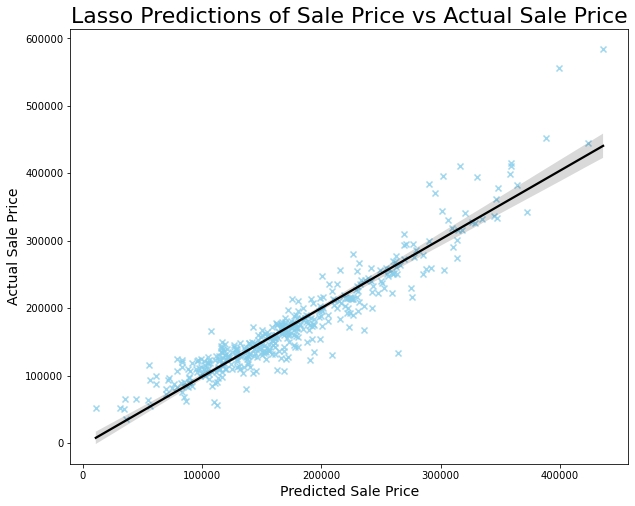

In [50]:
# Scatterplot to show predicted values versus actual values
lasso_f_preds = lasso_f.predict(X_f_test_sc)

plt.figure(figsize=(10,8))
sns.regplot(data=X_f_train, x=lasso_f_preds, y=y_f_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicted Sale Price', fontsize=14)
plt.ylabel('Actual Sale Price', fontsize=14)
plt.title('Lasso Predictions of Sale Price vs Actual Sale Price', fontsize=22)

The line of best fit passes through most of the points and we are happy with how the model has performing, barring a few outliers at the extreme `SalePrice` range.

Text(0.5, 1.0, 'Residuals')

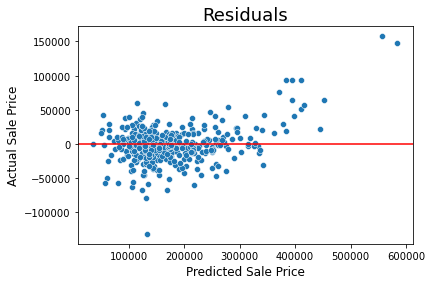

In [51]:
# plot residuals to check if they are equally distributed
ax = sns.scatterplot(data=df, x=y_f_test, y=y_f_test-lasso_f_preds)
ax.axhline(y=0, c='red')
plt.xlabel('Predicted Sale Price', fontsize=12)
plt.ylabel('Actual Sale Price', fontsize=12)
plt.title('Residuals', fontsize=18)

We can see here that the residuals are mostly equally distributed, which supports the multiple linear regression assumption of homoscedasticity, where the variance of error terms must be similar across the values of the independent variables. There are a few points, where we are do not observe this, and there could be any number of reasons for this, such as:
1. An unknown feature that affect `SalePrice` such as `Inflation`.
2. Incorrect data recording of values, e.g. how we had to impute values for `Lot Frontage`.

In order to finish our task of giving recommendations, let's take a look at the top 30 features as per our model.

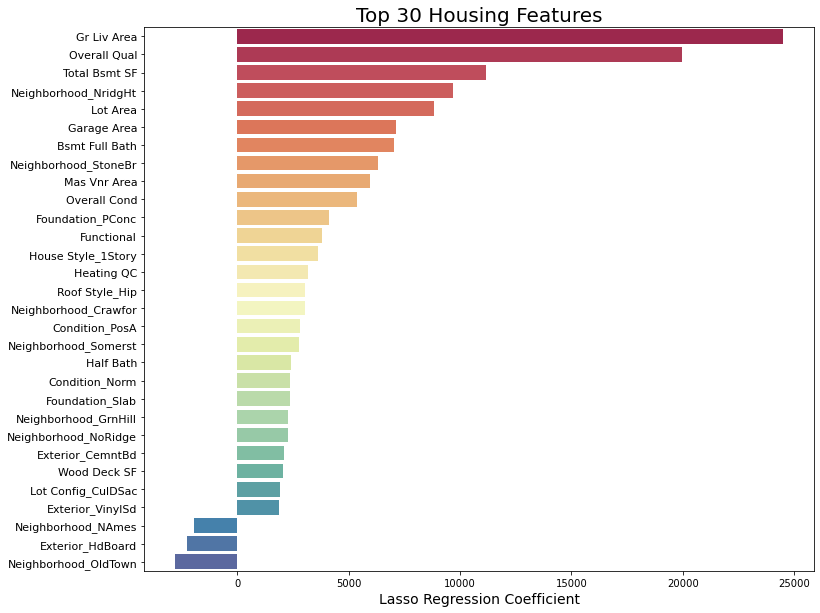

In [52]:
# Create dataframe of features, coefficients and absolute coefficients
lasso_df = pd.DataFrame(columns=['Feature', 'Coef', 'Abs Coef'])
lasso_df['Abs Coef'] = abs(lasso_f.coef_)
lasso_df['Coef'] = lasso_f.coef_
lasso_df['Feature'] = final_feat

# Plot top 30 features (sorted by absolute regression coefficient)
plt.figure(figsize=(12,10))
data = lasso_df.sort_values(by='Abs Coef', ascending=False).head(30)[['Feature', 'Coef']] \
               .sort_values(by='Coef', ascending=False).reset_index(drop=True)
    
ax = sns.barplot(data=data, y='Feature', x='Coef', orient='h', palette='Spectral')
ax.set_ylabel('')
ax.set_yticklabels(data['Feature'], size=11)
ax.set_xlabel('Lasso Regression Coefficient', fontsize=14)
plt.title('Top 30 Housing Features', fontsize=20);

In [53]:
# display the top 20 and bottom 10 coefficients
data

Feature          Coef
0            Gr Liv Area  24519.499400
1           Overall Qual  19971.385889
2          Total Bsmt SF  11180.449259
3   Neighborhood_NridgHt   9684.080625
4               Lot Area   8855.183310
5            Garage Area   7113.684190
6         Bsmt Full Bath   7048.104238
7   Neighborhood_StoneBr   6309.730027
8           Mas Vnr Area   5981.625445
9           Overall Cond   5385.001025
10      Foundation_PConc   4100.003089
11            Functional   3823.536812
12    House Style_1Story   3619.833325
13            Heating QC   3162.977734
14        Roof Style_Hip   3057.205827
15  Neighborhood_Crawfor   3055.496834
16        Condition_PosA   2835.602584
17  Neighborhood_Somerst   2782.422924
18             Half Bath   2415.850640
19        Condition_Norm   2379.339537
20       Foundation_Slab   2375.242531
21  Neighborhood_GrnHill   2294.137011
22  Neighborhood_NoRidge   2284.795542
23      Exterior_CemntBd   2108.492566
24          Wood Deck SF   2066.649681
25    Lot Config_CulDSac   1936.061922
26      Exterior_VinylSd   1888.965055
27    Neighborhood_NAmes  -1921.760503
28      Exterior_HdBoard  -2242.040856
29  Neighborhood_OldTown  -2812.443531

Our top predictive features make sense, they are related to `Square Footage` of the property, as well as the `Quality` of the property. Home `Functionality` was also and important predictive factor when it came to the `SalePrice`. 

Certain `Neighborhoods` automatically have higher prices showing those are highly preferred, whereas those in places like `OldTown` suffered due to it's location. Having 2 stories also hurt the `SalePrice`.

A client in that area would need to do as much as possible to capitalize on the other factors, e.g. the `Gr Liv Area` to fetch the highest price possible.

---

## Recommendations

Recommendations
Based on our model, the Interior Design and Renovation Firm can make the following recommendations to their clients and potentially take the actions on their behalf.

- Try to increase the overall and exterior quality of their home through renovation.
- Ensure Heating Quality is excellent, and consider changing Heating type to Wall Furnace, if you have any other style.
- Switch to a cement, brick or vinyl siding, wood shingles exterior. Avoid hardboard, wood siding, or plywood. A change is especially needed if you have one of these three.
- Improve garage size.
- The house style that created a maximum improvement in `SalePrice` was the 1 storey type, followed by Split Foyer and Split Level.
- Increase Basement Square Footage if possible.
- If there are no Bathrooms in the basement, add a full Bath, or a half Bath if full is not possible
- If you already have a half bath, consider upgrading to full bath.

With these suggestions, clients will surely see an increase in the value of the `SalePrice` of their property.

### Model Shortcomings

While this model generalizes well to the city of Ames, it's probably not generalizable to other cities, given that each city tends to differ greatly in terms of external factors.

Another point to keep in mind that this model doesn't take into account the inflation of housing prices. Since the end of the financial crisis in 2008, housing prices throughout the US have been increasing steadily year over year. The model will need to take this factor into account and would need retraining with new data, and most likely it would affect the feature selection as well.

**Improvements**:
- One improvement to make is to insist that all data is filled in before presented to us
- Another improvement is to select features algorithmically instead of common sense so as to ensure no important features are missed out.
- Account for interactivity between factors, e.g. A house that is 1 Storey AND has a Basement vs one that is only 1 Storey with no Basement.

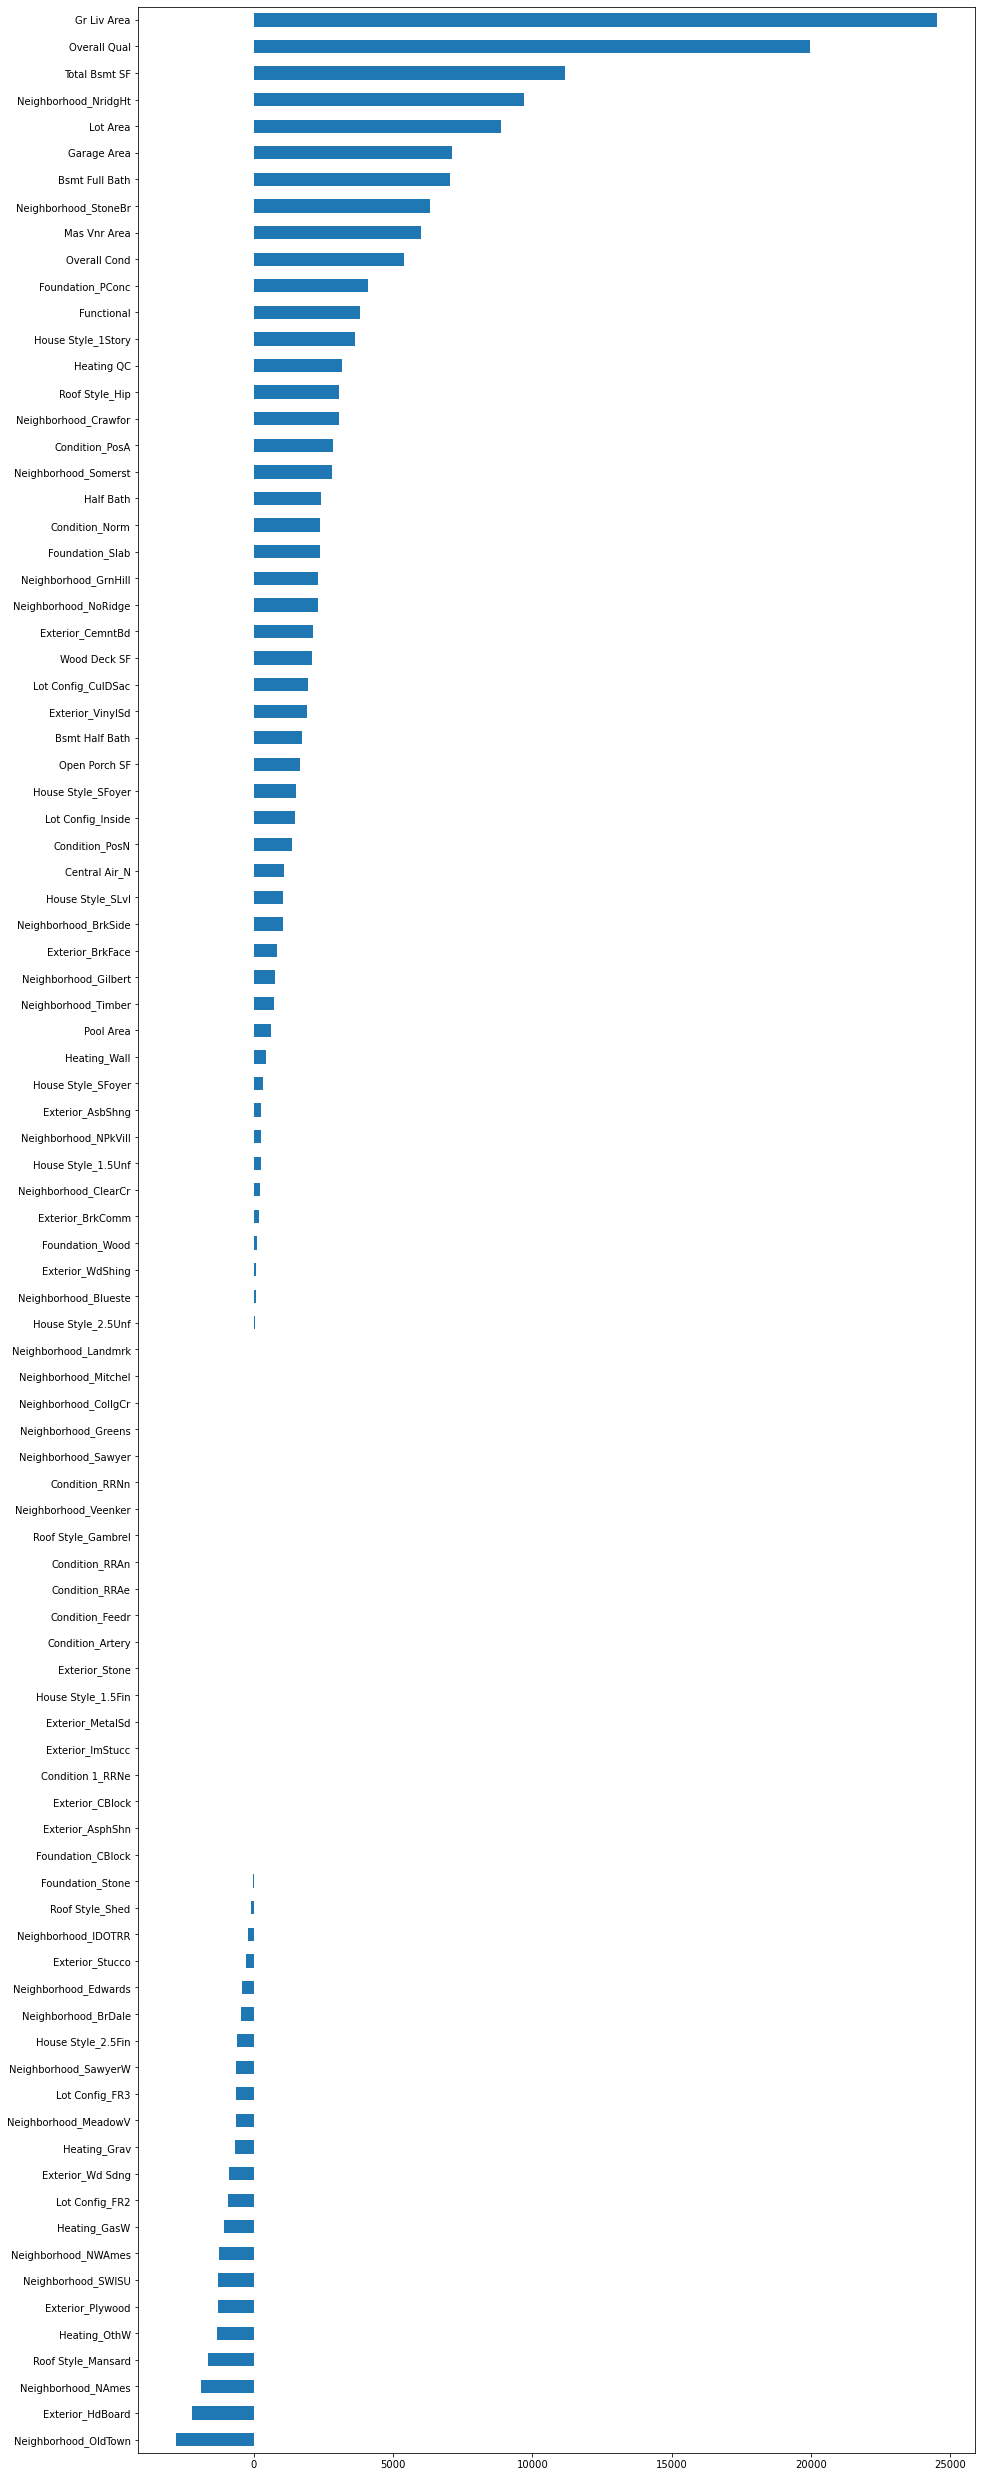

In [54]:
# Full plot of all features and lasso coefficients
pd.Series(lasso_f.coef_, index=final_feat).sort_values().plot.barh(figsize=(15,45));